<img src=https://raw.githubusercontent.com/superwise-ai/quickstart/f395a719ac93377005c6ce8bacebc425bf667cf1/docs/images/white_mode_logo.svg 
width="400" alt="Superwise">


# 🎉 **<font color='008aec'>Getting Started</font>**



This guide will walk you through the creation and configuration of a new model on the platform - giving you model observability in 5 minutes!


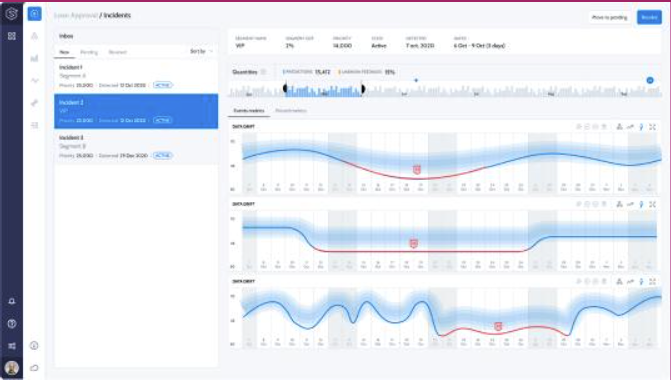


[1. Import Superwise package](#import_superwise_package)

[2. Simulate model training flow](#simulate_model_training_flow)

[3. Let's integrate with Superwise](#lets_integrate_with_superwise)
- [3.1 Create a Project](#create_a_project)
- [3.2 Create a Model](#create_a_model)
- [3.3 Create a Version](#create_a_version)
- [3.4 Create a Policy](#create_policy)
  - [3.4.1 Configure notification channel](#create_notification)
  - [3.4.2 Create Policy](#config_policy)
- [3.5 Log production data](#log_production_data)

#### ***Prerequisite packages***

In [ ]:
!pip install superwise  > /dev/null 2>&1 && echo "Superwise installation finished sucessfully"

Superwise installation finished sucessfully


### Restart the kernel

Once you've installed everything, you need to restart the notebook kernel so it can find the packages.

# 📦️ <font color='008aec'><a name="import_superwise_package">**Import Superwise package**</a></font>

In [ ]:
import os

# Automatically restart kernel after installs
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

The Superwise SDK is a standard Python package that simplifies the integration with Superwise and streams data to the Superwise platform.

For demostration purpose we will use:
* pandas for loading our diamonds data & working with dataframes
* numpy for dataframe operations
* sklearn for default ML operations such as train-test split, encoders, model trainning etc

Clarifications:
* Superwise.models.project.Project - represents an isolated project space that holds models
* Superwise.models.model.Model - represents an ML model in production
* Superwise.models.version.Version - represents a particular model form, with baseline data and features
* DataEntityRole - describes the dtype and role of the feature

In [ ]:
import os

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

from superwise import Superwise
from superwise.models.project import Project
from superwise.models.model import Model
from superwise.models.version import Version
from superwise.resources.superwise_enums import DataEntityRole
from superwise.resources.superwise_enums import NotifyUpon, ScheduleCron

<a name="initiate_superwise_client"></a>
## <font color='008aec'>**Initiate Superwise client**</font>

There are 2 environment variables used to identify and authenticate your connection:
* SUPERWISE_CLIENT_ID
* SUPERWISE_SECRET

Read [here](https://docs.superwise.ai/docs/authentication) to understand how to
 generate them.


In [ ]:
os.environ['SUPERWISE_CLIENT_ID'] = '[REPLACE_WITH_YOUR_CLIENT]'
os.environ['SUPERWISE_SECRET'] = '[REPLACE_WITH_YOUR_SECRET]'

To interact with the Superwise APIs, create an instance of the Superwise object. All APIs will now be accessible under the sw instance.


In [ ]:
sw = Superwise()

<a name="simulate_model_training_flow"></a>
# 🤡 <font color='008aec'>**Simulate model training flow**</font>

For this tutorial, we use the Diamonds public dataset. This classic dataset contains the prices and other attributes of almost 54,000 diamonds.


#### Load data

In [ ]:
diamonds = pd.read_csv('https://www.openml.org/data/get_csv/21792853/dataset')
diamonds.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


Dataset properties:
- carat weight of the diamond (0.2--5.01)
- cut quality of the cut (Fair, Good, Very Good, Premium, Ideal)
- color diamond color, from J (worst) to D (best)
- clarity a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))
- depth total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)
- table width of top of diamond relative to widest point (43--95)
- price price in US dollars ($326--$18,823) - Label
- x length in mm (0--10.74)
- y width in mm (0--58.9)
- z depth in mm (0--31.8)


#### Split Train-Test

We’ll split the dataset into training and test sets. The training dataset will be used later as a reference dataset for the baseline. The test dataset will simulate production data that feeds into the model. You can read more about the baseline dataset concept [here](https://docs.superwise.ai/docs/baseline)


In [ ]:
X = diamonds.drop(columns="price")
y = diamonds["price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.head()

,carat,cut,color,clarity,depth,table,x,y,z
19497,1.21,Ideal,H,VVS2,61.3,57.0,6.92,6.87,4.23
31229,0.31,Ideal,E,VS2,62.0,56.0,4.38,4.36,2.71
22311,1.21,Ideal,E,VS1,62.4,57.0,6.75,6.83,4.24
278,0.81,Ideal,F,SI2,62.6,55.0,5.92,5.96,3.72
6646,0.79,Ideal,I,VVS2,61.7,56.0,5.94,5.95,3.67


#### Pre-processing

To use categorical features in our model, we will first transform them into numerical values using [one-hot encoding](https://en.wikipedia.org/wiki/One-hot)

In [ ]:
categorical_cols = ['cut', 'clarity', 'color']

preprocessor = ColumnTransformer(
    transformers=[
        ('categorical',  OneHotEncoder(), categorical_cols)
    ], remainder='passthrough')

#### Train your model

In this example, we train a simple Liner Regression

In [ ]:
diamond_price_model=LinearRegression()

my_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', diamond_price_model)
])

my_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OneHotEncoder(),
                                                  ['cut', 'clarity',
                                                   'color'])])),
                ('model', LinearRegression())])

#### Predict

We can now use the model we trained to predict the price


In [ ]:
y_pred_train =  my_pipeline.predict(X_train)

<a name="lets_integrate_with_superwise"></a>
# 🧑‍💻 <font color='008aec'>**Let's integrate with Superwise**</font>

Now that we have a trained model, we can begin by logging it into the Superwise platform and starting to monitor its behavior.


<a name="create_a_project"></a>
#### Create a Project

A *Project* represents an isolated working environment.

A project can hold many models, but a model can only (and must) have 1 project.

In [ ]:
project = Project(
    name="My First Project",
    description="project for my first model"
)

project = sw.project.create(project)
print(f"New project Created - {project.id}")

New project Created - 2


<a name="create_a_model"></a>
#### Create a Model

Models, or machine learning-based decision processes are the basic atomic component that Superwise observes

In [ ]:
diamond_model = Model(
    name="Diamond Model",
    description="Regression model that predicts the diamond price",
    project_id=project.id
)

diamond_model = sw.model.create(diamond_model)
print(f"New model Created - {diamond_model.id}")

New model Created - 29


A new model will appear in [superwise.ai](https://portal.superwise.ai)
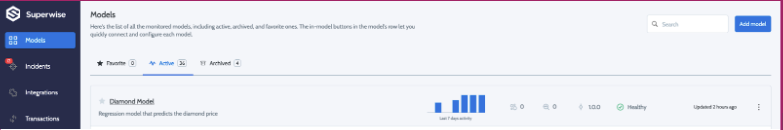

<a name="create_a_version"></a>
#### Create a Version

Deploying a model to production is only the first step, since models require continuous improvement and ongoing updates. The differences between versions may be ad hoc schema changes or retraining on a new data set to refit the model hyperparameters under the same given schema.

The process contains 3 main steps 
    - Prepare the baseline dataset based on the training data
    - Define the version schema
    - Log the version into the Superwise app

#### Prepare Baseline Dataset

We’re now going to add 4 columns to our dataset
* ID - Unique identifier per row or prediction (Required)
* Timestamp - Indicates when the prediction took place (Required)
* Model prediction
* Label - The real diamond price

In [ ]:
baseline_data = X_train.assign(
    id=X_train.index,
    ts=pd.Timestamp.now(),
    prediction=y_pred_train,
    price=y_train
)
baseline_data["prediction"] = baseline_data["prediction"].astype(float)

data_dir = 'data'
baseline_data_filename = 'baseline.csv'
if not os.path.exists(data_dir):
    os.mkdir(data_dir)
baseline_data_filepath = os.path.join(data_dir, baseline_data_filename)  

baseline_data.to_csv(baseline_data_filepath, index=False)
baseline_data.head()

,carat,cut,color,clarity,depth,table,x,y,z,id,ts,prediction,price
19497,1.21,Ideal,H,VVS2,61.3,57.0,6.92,6.87,4.23,19497,2022-05-16 13:43:55.089873,8058.84375,8131
31229,0.31,Ideal,E,VS2,62.0,56.0,4.38,4.36,2.71,31229,2022-05-16 13:43:55.089873,600.93750,756
22311,1.21,Ideal,E,VS1,62.4,57.0,6.75,6.83,4.24,22311,2022-05-16 13:43:55.089873,8569.37500,10351
278,0.81,Ideal,F,SI2,62.6,55.0,5.92,5.96,3.72,278,2022-05-16 13:43:55.089873,3041.40625,2795
6646,0.79,Ideal,I,VVS2,61.7,56.0,5.94,5.95,3.67,6646,2022-05-16 13:43:55.089873,3860.59375,4092


#### Infer schema

Because each model version can introduce new input formats, we must have an explicit schema definition for each version. The schema is a collection of different data entities (aka columns) that are part of the specific version of the machine learning decision process. Each data entity has its own data type and plays a specific role in the ML process.

You can read more about the roles of data entities and supported data types [here](https://docs.superwise.ai/docs/version)

In [ ]:
entities_collection = sw.data_entity.summarise(
    data=baseline_data,
    specific_roles = {
      'id': DataEntityRole.ID,
      'ts': DataEntityRole.TIMESTAMP,
      'prediction': DataEntityRole.PREDICTION_VALUE,
      'price': DataEntityRole.LABEL
    }
) # This line performs computations over the baseline data, therefore execution time might be serval minutes

Here are the schema’s main properties, which include roles, types, feature importance, and descriptive statistics:


In [ ]:
ls = list()
for entity in entities_collection:
    ls.append(entity.get_properties())
    
pd.DataFrame(ls).head()

,data_type,dimension_start_ts,feature_importance,id,name,role,secondary_type,summary,type
0,number,None,61.41,None,carat,feature,Num_centered,"{'statistics': {'missing_values': 0.0, 'outlie...",Numeric
1,text,None,0.01,None,cut,feature,Cat_dense,"{'statistics': {'missing_values': 0.0, 'new_va...",Categorical
2,text,None,6.12,None,color,feature,Cat_dense,"{'statistics': {'missing_values': 0.0, 'new_va...",Categorical
3,text,None,11.10,None,clarity,feature,Cat_dense,"{'statistics': {'missing_values': 0.0, 'new_va...",Categorical
4,number,None,0.01,None,depth,feature,Num_centered,"{'statistics': {'missing_values': 0.0, 'outlie...",Numeric


#### Activate a version

Now that we have a model and schema, let’s combine them together into a version.


In [ ]:
new_version = Version(
    model_id=diamond_model.id,
    name="1.0.0",
    data_entities=entities_collection,
)

new_version = sw.version.create(new_version)

In [ ]:
sw.version.activate(new_version.id)

<Response [200]>

We should now see activated version in Diamond Model Versions page
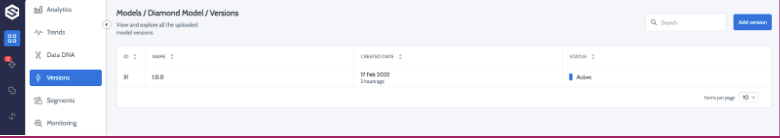

<a name="create_policy"></a>
## 📄 <font color='008aec'>**Create Policy**</font>
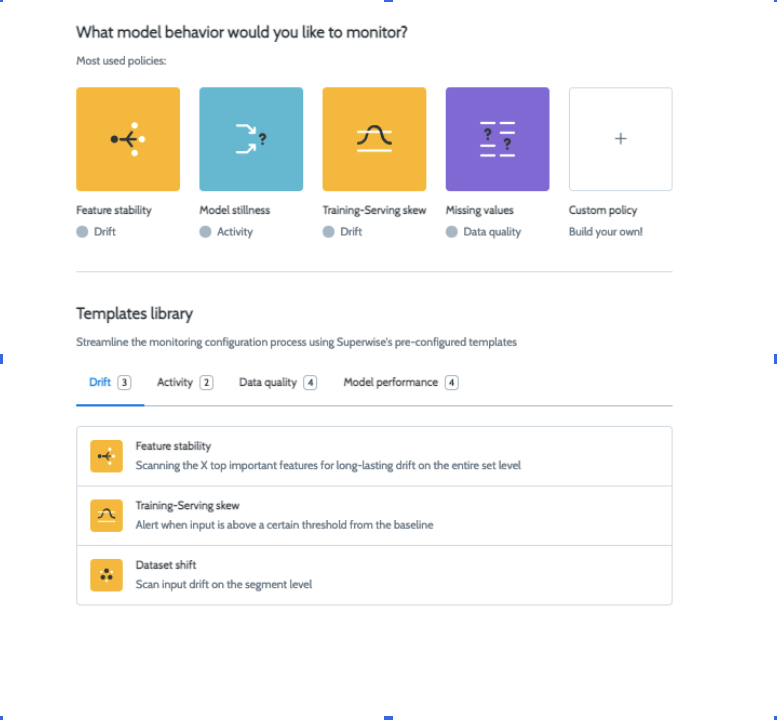

Before we starting send data to the system, let's configure a policy to notify us on anomalies detected by Superwise platform.

For that let's create a notification channel where we will be notified on all the anomalies found by Superwise platform.  

*After creating the notification channel*, we will list all th policy templates available and choose 
a template to create the policy from.

In [ ]:
notification = sw.notification.create_email_notification(name="demo_email",email="demo@superwise.ai")
print(notification.get_properties())

{'created_at': '2022-05-16 10:44:19', 'id': 3, 'is_enabled': True, 'is_hide': False, 'last_delivery_status': 'Unknown', 'last_delivery_ts': None, 'name': 'demo_email', 'notification_metadata': {'target': ['demo@superwise.ai']}, 'type': 'Email'}


In [ ]:
templates = sw.policy.get_policy_templates()
templates

,name,description
0,Feature stability,Scanning the X top important features for long...
1,Dataset shift,Scan input drift on the segment level
2,Training-Serving skew,Alert when input is above a certain threshold ...
3,Missing values,Missing values on a feature level on a segment...
4,Out-of-Range,Anomaly in % of outliers on a feature level (n...
5,New values,Anomaly in % of new values on a feature level ...
6,Prediction shift,Shift in the model predictions on a segment level
7,Decision proportion,Proportion of a specific decision is above a c...
8,Label shift,
9,Label proportion,


In [ ]:
template_name = 'Feature stability'	
response = sw.policy.create_policy_from_template(policy_name='my policy',model_id=diamond_model.id, template_name=template_name, notify_upon=NotifyUpon.detection, schedule=ScheduleCron.EVERY_DAY_AT_6AM,notification_channels=[notification])
response.json()

{'id': 160,
 'name': 'my policy',
 'task_id': 29,
 'rules': [[225]],
 'notify_upon': 'detection',
 'status': 'active',
 'segment_ids': [],
 'segments_to_monitor': 'entire',
 'minimal_incident_length': 3.0,
 'minimum_quantity': 0,
 'updated_at': 1652688656,
 'created_at': 1652698097,
 'created_by': 'dde99ff3-8273-4d7b-8fa8-eb073effc6d8',
 'monitor_offset': 1,
 'time_unit': 'D',
 'monitored_until': None,
 'schedule': '0 06 * * *',
 'notifications': [3],
 'model_id': 29}

<a name="log_production_data"></a>
## 🔊 <font color='008aec'>**Log production data**</font>

We’ll now use the test data to simulate production data.


#### Predictions

The prediction data should include all the data entities with the following roles - Id, Timestamp, Metadata, Feature, Prediction probability, Prediction value, Label weight -- as defined in the version schema above. In our diamonds example, we’ll add the following columns: Id, Timestamp, and Model prediction.
If some data entities are missing, you’ll get a schema skew error, which means that the data will not be streaming into Superwise.

In [ ]:
y_test_pred= my_pipeline.predict(X_test)

In [ ]:
prediction_time_vector = pd.Timestamp.now().floor('h') - \
    pd.TimedeltaIndex(X_test.reset_index(drop=True).index // int(X_test.shape[0] // 30), unit='D')

ongoing_predictions = X_test.assign(
    id=X_test.index,
    ts=prediction_time_vector,
    prediction=y_test_pred
)
ongoing_predictions["prediction"] = ongoing_predictions["prediction"].astype(float)
ongoing_predictions.to_csv('data/ongoing_predictions.csv', index=False)
ongoing_predictions.head()

,carat,cut,color,clarity,depth,table,x,y,z,id,ts,prediction
1388,0.24,Ideal,G,VVS1,62.1,56.0,3.97,4.00,2.47,1388,2022-05-16 13:00:00,701.34375
50052,0.58,'Very Good',F,VVS2,60.0,57.0,5.44,5.42,3.26,50052,2022-05-16 13:00:00,3202.53125
41645,0.40,Ideal,E,VVS2,62.1,55.0,4.76,4.74,2.95,41645,2022-05-16 13:00:00,1941.59375
42377,0.43,Premium,E,VVS2,60.8,57.0,4.92,4.89,2.98,42377,2022-05-16 13:00:00,2068.34375
17244,1.55,Ideal,E,SI2,62.3,55.0,7.44,7.37,4.61,17244,2022-05-16 13:00:00,9879.46875


After we fit the data according to the schema, it’s ready to be sent to the Superwise platform. You’ll need to provide the model and the version of the model being used for the prediction.

Notice that each chunk of data should not be more than 1000 records.


In [ ]:
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

🚧 
While the next snippet is running, open [transactions](https://portal.superwise.ai) page within Superwise portal to see the data being loaded.


We should now see the transactions table filled with data
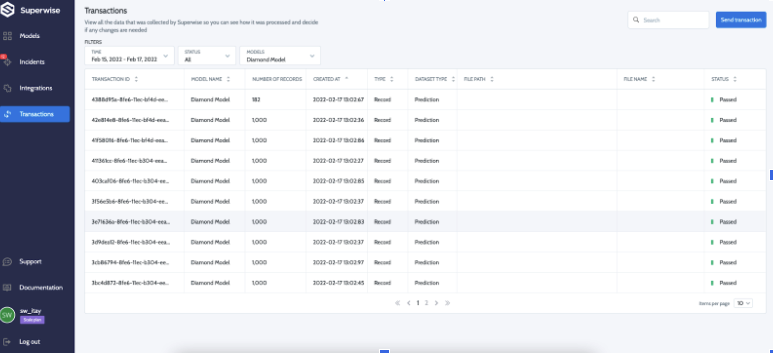

In [ ]:
transaction_id = sw.transaction.get(transaction_id=transaction_ids[0]['transaction_id'])
transaction_id.get_properties()['status']

'Passed'

#### Ground truth

In most ML scenarios, the ground truth comes back with a delay. To log it correctly, the data should include all the data entities with the following roles: Id, Label (as we defined in the schema). Superwise will automatically add them to the predictions that were sent earlier and use them to calculate the model performance metrics.

In [ ]:
ongoing_labels = y_test.reset_index().copy().rename(columns={"index": "id"})
ongoing_labels.to_csv('data/ongoing_labels.csv', index=False)
ongoing_labels.head()

,id,price
0,1388,559
1,50052,2201
2,41645,1238
3,42377,1304
4,17244,6901


You’ll notice that when you log the ground truth, the version_id is optional. For example, if you use 2 different versions to predict the same data record, the ground truth is relevant for both of them.

In [ ]:
transaction_id = sw.transaction.get(transaction_id=transaction_ids[0]['transaction_id'])
transaction_id.get_properties()['status']

'Passed'